In [1]:
%matplotlib notebook
from matplotlib.pyplot import subplots
from matplotlib.patches import Ellipse
from theano_models.visualization import d3viz
from IPython.display import IFrame

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from __future__ import division

In [3]:
from theano_models import fix_params, Reparameterize, Flatten, Merge, normalizing_flow
import theano_models.tools as tt
import theano_models.probabilistic_models as pm
import theano_models.deterministic_models as dm
import theano_models.postmaps as post
import numpy as np
import time
from climin.util import optimizer
from schlichtanders.myfunctools import compose, meanmap
from schlichtanders.mygenerators import chunk as ichunk
from itertools import izip, imap, repeat as irepeat, count as icount, cycle as icycle, islice

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


# Model

In [4]:
base = fix_params(pm.Gauss(2))
base

Gauss_fixed { 'inputs': [],
  'logP': <FunctionWrapper at 0x7f62bb2fe980 for function at 0x7f62bb30a500>,
  'outputs': GaussianNoise.outputs,
  'parameters': [],
  'parameters_positive': []}

In [5]:
locscale = dm.LocScaleTransform()
locscale

LocScaleTransform { 'inputs': [LocScaleTransform.inputs.0],
  'norm_det': LocScaleTransform.norm_det,
  'outputs': LocScaleTransform.outputs,
  'parameters': [loc],
  'parameters_positive': [scale]}

In [6]:
model = normalizing_flow(locscale, base)
model

normalized_flow { 'inputs': [],
  'logP': <FunctionWrapper at 0x7f62bb33c4b0 for function at 0x7f62f1912398>,
  'norm_det': LocScaleTransform.norm_det,
  'outputs': LocScaleTransform.outputs,
  'parameters': [loc],
  'parameters_positive': [scale]}

In [7]:
model = Merge(model, Reparameterize(model['parameters_positive'], tt.softplus, tt.softplus_inv))
model = Merge(model, Flatten(model['parameters']))
model

Merge2 { 'flat': "loc:scale_softplus",
  'inputs': [],
  'logP': <FunctionWrapper at 0x7f62bb33c4b0 for function at 0x7f62f1912398>,
  'norm_det': LocScaleTransform.norm_det,
  'outputs': LocScaleTransform.outputs,
  'parameters': [],
  'parameters_positive': []}

# Target

In [8]:
target = pm.Gauss(init_mean=[3,1], init_var=4)
t_sampler = target.function()
targets = np.array([t_sampler() for _ in range(10000)])
targets[:10]

array([[ 2.64223102,  1.22116534],
       [ 4.19496515,  2.02504374],
       [ 2.90114038, -1.50180972],
       [ 4.88504949,  0.94543856],
       [ 6.16598619,  0.925433  ],
       [ 5.05939522,  4.13974724],
       [ 1.7581368 ,  0.28420688],
       [ 2.12837604,  1.22905417],
       [ 4.54913688,  1.12832409],
       [ 3.10284973,  3.02398645]])

# Visualized Fit

In [9]:
target_mean = target.mean.eval()
target_var = target.var.eval()
target_var = [target_var, target_var]
    
def plot_fit(fig, ax, givens={}, time_delay=0.1):
    ax.clear()
    
    # plot target
    # -----------
    # Data
    ax.plot(targets[:500,0], targets[:500,1], 'k.')
    # Ellipse
    e = Ellipse(target_mean, width=2*np.sqrt(target_var[0]), height=2*np.sqrt(target_var[1]))
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.1)
    e.set_facecolor([1, 0.1, 0.1])
    ax.add_patch(e)

    # plot model
    # -----------
    model_mean = model.loc.eval(givens)
    model_var = model.scale.eval(givens)**2
    model_var = [model_var, model_var]
    # text
    ax.text(0.1, 0.2, 'm=%g,%g' % tuple(model_mean),
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes)
    ax.text(0.1, 0.1, 'v=%g,%g' % tuple(model_var),
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes)
    # Ellipse
    e = Ellipse(model_mean, width=2*np.sqrt(model_var[0]), height=2*np.sqrt(model_var[1]))
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.2)
    e.set_facecolor([0.1, 0.2, 0.4])
    ax.add_patch(e)
    # Point  # we need to add a normal plot, as then the axis adjust automatically
    ax.plot(model_mean[0], model_mean[1], '+', color=[0.1, 0.2, 0.4], markersize=10)
    
    # interactively redraw
    # --------------------
    fig.canvas.draw()
    if time_delay is not None:
        time.sleep(time_delay) # just because the fit is to fast otherwise

<IPython.core.display.Javascript object>


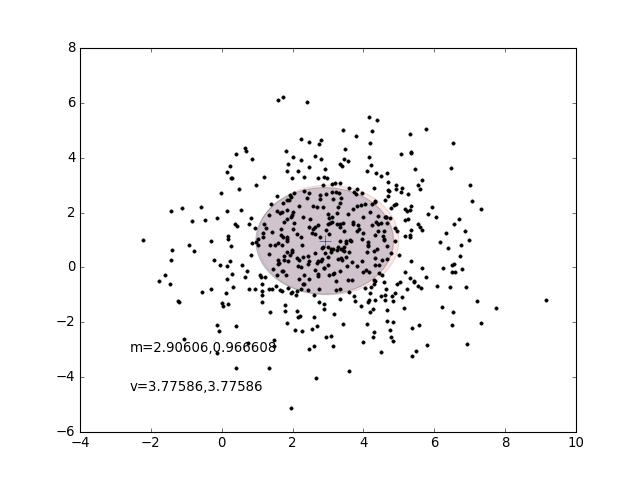

In [13]:
fig, ax = subplots()
ax.set_xlabel("x0")
ax.set_ylabel("x1")
plot_fit(fig, ax)

In [16]:
batch_size = 100
postmap = compose(post.climin_postmap, post.flat_numericalize_postmap, post.probabilistic_optimizer_postmap)
climin_kwargs = postmap(model, mapreduce=meanmap)
climin_args = izip(imap(lambda x:(x,), ichunk(batch_size, icycle(targets))), irepeat({}))
opt = optimizer(
    identifier="adadelta",
    args=climin_args,
    **climin_kwargs
)

In [17]:
for info in islice(opt, 200):
    plot_fit(fig, ax, givens={model['flat']:opt.wrt}, time_delay=None)